In [55]:
%matplotlib inline
import sys
import random
from math import floor
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os, glob, math,time
import multiprocessing
import sys
sys.path.append('/home/r120084/pytorch_lib/pytorch/')


from scipy import misc
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision import models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision


import lib.pytorch_trainer as ptt

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm 
from sklearn.preprocessing import MultiLabelBinarizer


In [56]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)
cpu_count = multiprocessing.cpu_count()
print('cpu_count: ', cpu_count)

GPU available: False
cpu_count:  12



# Choose dataset 

In [57]:
path2train = "/home/e209440/data/train"
path2test = "/home/e209440/data/test"

In [58]:
labels = {  'c0' : 'safe driving', 
            'c1' : 'texting - right', 
            'c2' : 'talking on the phone - right', 
            'c3' : 'texting - left', 
            'c4' : 'talking on the phone - left', 
            'c5' : 'operating the radio', 
            'c6' : 'drinking', 
            'c7' : 'reaching behind', 
            'c8' : 'hair and makeup', 
            'c9' : 'talking to passenger'}

In [59]:
def get_traindata_path(path, labels):
    print('Loading train dataset...')
    X_train= []
    y_train = []
    ii_n = len(labels)
    for i, label in enumerate(labels):
        path_folder = os.path.join(path, str(label), '*.jpg')
        files = glob.glob(path_folder) 
        X_train.extend(files)
        y_train.extend([int(label[-1])]*len(files))
        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print('\nok')
   
    return X_train,y_train

In [60]:
def get_testdata_path(path):
    print('\nLoading test dataset...')
    X_test    = []
    path  = os.path.join(path2test, '*.jpg')
    files = glob.glob(path)
    X_test.extend(files)  
    print('ok')
    return X_test

In [61]:
def get_driver_data(path2train, path2test, labels):
    
    X_train, Y_train = get_traindata_path(path2train, labels)
    X_test = get_testdata_path(path2test)
    
    data = {}
    data['X_train'] = X_train
    data['y_train'] = Y_train
    data['X_test'] = X_test
    return data

In [62]:
data = get_driver_data(path2train, path2test, labels)

Loading train dataset...
predict: 9/9
ok

Loading test dataset...
ok


# Dataset Class with split data, transformations and onehot code 

In [63]:
class KaggleSafeDriverDataset(Dataset):
    """
    Arguments:
        Path to data (redux or not)
        PIL transforms
        Test data (boolean)
        Validation data (boolean)
        Size of validation data 
        Shuffle indices of validation and Train
        
    """

    def __init__(self, tmp_data, use_only =1.0, transforms=None, \
                 is_test=False,is_val=False,val_size=0.2):
    
        self.transform = transforms        
        if is_test:
            
            length = len(tmp_data['X_test'])
            only = int(use_only * length)
            self.X = tmp_data['X_test'][:only]
            
            self.y = None #Gambiarra para poder criar DataSet do Test.
        
        else:
            
            length = len(tmp_data['X_train'])
            indices = list(range(0,length))
            
            nr.seed(4572)
            ind = nr.permutation(indices)
            
            
            length = ind.shape[0]
            only = int(use_only * length)
            
            ind = ind[:only]
            length = ind.shape[0]
            
            split = int(val_size * length)
            
            if is_val:
                self.X = [tmp_data['X_train'][i] for i in ind[:split]]
                self.y = [tmp_data['y_train'][i] for i in ind[:split]]
            else:
                self.X = [tmp_data['X_train'][i] for i in ind[split:]]
                self.y = [tmp_data['y_train'][i] for i in ind[split:]]
                
    def __getitem__(self, index):
        path = self.X[index]
        label = self.y[index]
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.X)
    

In [64]:
batch_size = 32
img_size ,img_width, img_height = 50, 50, 50
use_only = 0.1 # Use only 20% of the full dataset

In [65]:
def my_transforms(img, img_width=img_width, img_height=img_height):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

In [66]:
# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


In [67]:
dsets = {
    'train': KaggleSafeDriverDataset(data, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(data, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(data, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [68]:
def _create_dataLoader(dsets, batch_size, cpu_count, pin_memory =  False):

    dset_loaders = {}
    for key in dsets.keys():
        dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, shuffle=True, num_workers=2*cpu_count, pin_memory=pin_memory)

    return dset_loaders

In [69]:
dset_loaders = _create_dataLoader(dsets, batch_size, cpu_count)

In [70]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid', 'test']}
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(1794, {'test': 7972, 'train': 1794, 'valid': 448})

# Plotting some examples

In [71]:
def plot_classes(dset_loaders, labels, path2save = './figures/data.png'):

    # Get a batch of training data
    inputs, cls = next(iter(dset_loaders))
    print(inputs[8].shape, cls.shape)
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,10)):
        fig.add_subplot(2,5, i+1)
        img = denormalize(inputs.numpy()[j])
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        plt.title('{}'.format(labels['c'+str(cls[j])]))
        plt.axis('off')
    fig.savefig(path2save)

torch.Size([3, 50, 50]) torch.Size([32])


/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


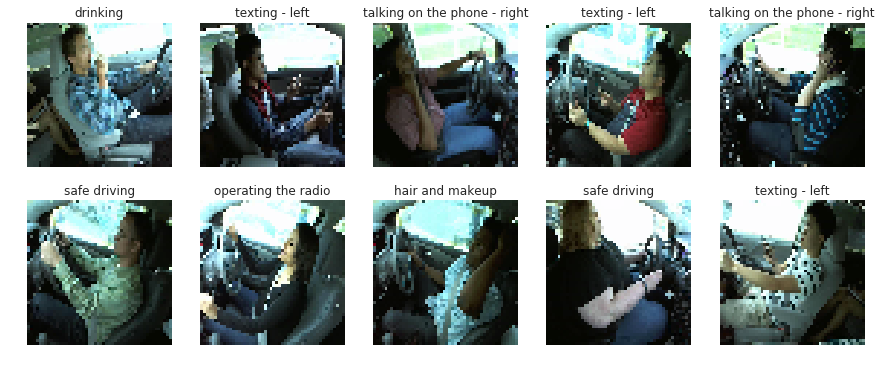

In [72]:
plot_classes(dset_loaders['train'], labels)

In [73]:
def plot_distribution(img):
    
    if img.shape[2] != 3:
        img = img.transpose((1, 2, 0))
        
    color_lst = ['red', 'green', 'blue']
    for i in range(0, img.shape[2]):
        c1=img[:,:,i].reshape(-1)
        plt.hist(c1, 50, facecolor=color_lst[i], label = color_lst[i])
    plt.legend()
    plt.grid(True)

In [74]:
def statistical_analysis_image(dset_loaders, labels, path2save = './figures/distribution.png'):

    
    fig = plt.figure(figsize=(15,6))
    inputs, cls = next(iter(dset_loaders))
    rand_idx = random.randrange(0, len(inputs))
    img = inputs.numpy()[rand_idx]
    img_denorm = denormalize(img)
    plt.subplot(2,2,2)
    plot_distribution(img_denorm)
    plt.title('Image RGB after denormalization')
    plt.subplot(2,2,4)
    plot_distribution(img)
    plt.title('Image RGB normalization')
    plt.subplot(1,2,1)
    img_denorm = np.clip(img_denorm, 0, 1.0)
    plt.imshow(img_denorm)
    plt.title('{}'.format(labels['c'+str(cls[rand_idx])]))
    plt.axis('off')
    fig.savefig(path2save)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


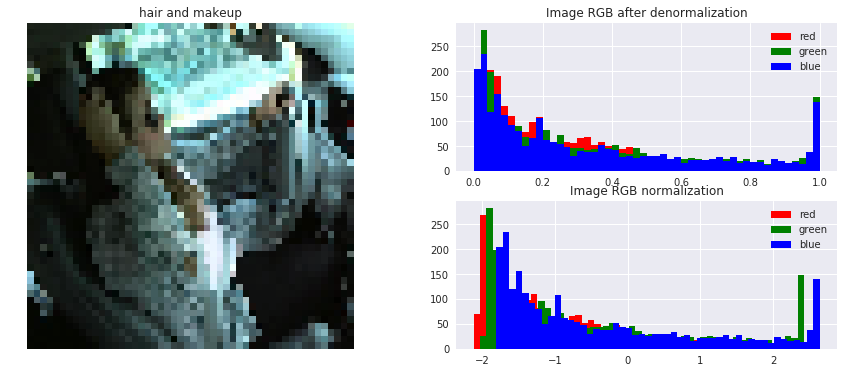

In [75]:
statistical_analysis_image(dset_loaders['train'], labels)

# Data Analysis

In [76]:
def code2label(dataset, labels): 
    class_str = []
    for item in dataset.y:
        class_str.append(labels['c'+str(item)])  
    return class_str           

In [77]:
class_str = code2label(dsets['train'], labels)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


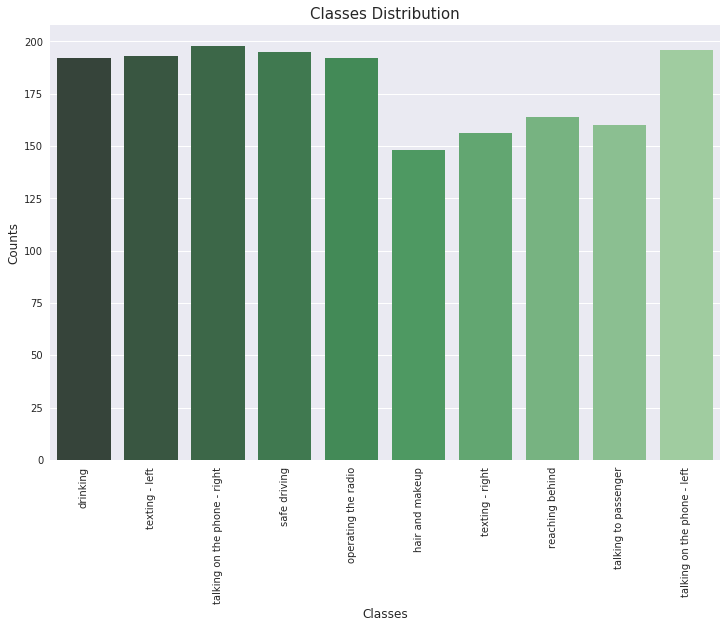

In [78]:
fig = plt.figure(figsize=(12,8))
sns.countplot(x=class_str, palette="Greens_d");
plt.xlabel("Classes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90)
plt.title("Classes Distribution", fontsize=15)
plt.show()
path2save = './figures/distribution_classes.png'
fig.savefig(path2save)

In [79]:
nb_out = len(set(class_str))

In [80]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self, fixed_extractor = True):
        super().__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
        
        del self.layer2
        del self.layer3
        del self.layer4
        del self.fc
        
        if fixed_extractor:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=64, out_features=32)
        self.dens2 = torch.nn.Linear(in_features=32, out_features=nb_out)
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = self.dens2(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

In [81]:
model = MyResNet()
if use_gpu:
    model.cuda()
    !free -h
    !nvidia-smi
    model = torch.nn.DataParallel(MyResNet())

In [82]:
print(model)

MyResNet (
  (mrnc): MyResNetConv (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

In [83]:
def predict_convolutional(dset_loaders, model, get_labels = False):

    predictions = []
    labels_lst = []
    ii_n = len(dset_loaders)

    for i, (inputs, labels) in enumerate(dset_loaders):
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs = Variable(inputs)
        predictions.append(model(inputs).data)
        if get_labels:
            labels_lst.append(labels)

        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return {'input': torch.cat(predictions, 0), 'ouput':torch.cat(labels_lst, 0) }

In [84]:
convOutput_train = predict_convolutional(dset_loaders['train'], model.mrnc, get_labels= True)
convOutput_valid = predict_convolutional(dset_loaders['valid'], model.mrnc, get_labels= True)

predict: 56/56 ok
predict: 13/13 ok


In [85]:
print(convOutput_train['input'].size(), convOutput_train['ouput'].size())
print(convOutput_valid['input'].size(), convOutput_valid['ouput'].size())

torch.Size([1794, 64]) torch.Size([1794])
torch.Size([448, 64]) torch.Size([448])


In [86]:
conv_dset ={
    'train': TensorDataset(convOutput_train['input'], convOutput_train['ouput']),
    'valid': TensorDataset(convOutput_valid['input'], convOutput_valid['ouput'])
} 

In [87]:
dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, cpu_count)

In [88]:
optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

In [89]:
savebest = ptt.ModelCheckpoint('/home/r120084/project/models/distractdriver',reset=False, verbose=1)

params = {'model' : model.mrnd, 
    'criterion': loss_fn,  
    'optimizer': optimizer, 
    'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
        }

In [106]:
trainer = ptt.DeepNetTrainer(**params)

In [107]:
trainer.fit_loader(200, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

Start training for 200 epochs
  1:   1.2s   T: 1.53885   V: 1.68777 best
  2:   0.9s   T: 1.53576   V: 1.68633 best
  3:   1.0s   T: 1.53424   V: 1.68525 best
  4:   1.1s   T: 1.53314   V: 1.68354 best
  5:   1.2s   T: 1.53131   V: 1.68308 best
  6:   1.3s   T: 1.53009   V: 1.68249 best
  7:   1.0s   T: 1.52870   V: 1.68212 best
  8:   1.2s   T: 1.52779   V: 1.68125 best
  9:   1.5s   T: 1.52610   V: 1.68048 best
 10:   1.0s   T: 1.52461   V: 1.67977 best
 11:   1.4s   T: 1.52365   V: 1.67987 
 12:   1.2s   T: 1.52238   V: 1.67893 best
 13:   1.3s   T: 1.52120   V: 1.67876 best
 14:   1.2s   T: 1.52036   V: 1.67859 best
 15:   1.6s   T: 1.51915   V: 1.67842 best
 16:   1.3s   T: 1.51827   V: 1.67746 best
 17:   0.9s   T: 1.51712   V: 1.67722 best
 18:   1.2s   T: 1.51626   V: 1.67698 best
 19:   1.2s   T: 1.51503   V: 1.67618 best
 20:   1.2s   T: 1.51382   V: 1.67577 best
 21:   1.0s   T: 1.51330   V: 1.67596 
 22:   1.0s   T: 1.51201   V: 1.67513 best
 23:   1.0s   T: 1.51103   V: 1.

In [108]:
if use_gpu:
    !free -h
    !nvidia-smi

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


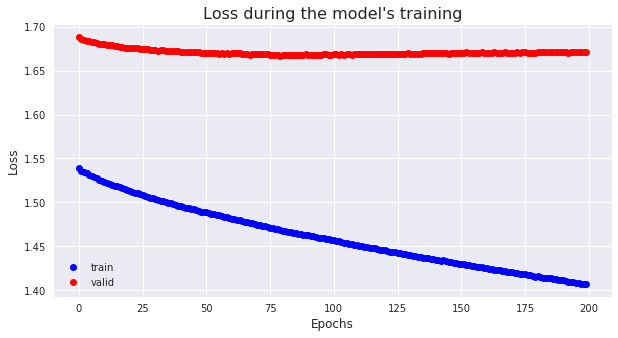

In [109]:
path2save = './figures/results_metrics.png'

fig = plt.figure(figsize=(10,5))
metrics_map = {'losses': 'Loss', 'acc': 'Acuracy'}

metrics_eval_nb = len(trainer.metrics['train'].keys())
count = 1
for metric in trainer.metrics['train'].keys():
    plt.subplot(1,metrics_eval_nb, count)
    plt.plot(trainer.metrics['train'][metric], 'ob', label = 'train')
    plt.plot(trainer.metrics['valid'][metric], 'or', label = 'valid')
    count += 1
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel(metrics_map[metric], fontsize = 12)
    plt.title(metrics_map[metric] + " during the model's training", fontsize = 16)
    plt.legend()
fig.savefig(path2save)

In [110]:
train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

evaluate: 56/56 ok
evaluate: 13/13 ok


In [111]:
train_eval, valid_eval

({'losses': 1.3742506349232948}, {'losses': 1.6712968690054757})

In [112]:
def predict_images(dset):

    output_true = []
    output_pred_lst = []
    correct = 0
    for i, (inputs, outputs) in enumerate(dset):
        if use_gpu:
            inputs = inputs.cuda()
            outputs = outputs.cuda()
        output_pred = trainer.predict(inputs)      
        _, predicted = torch.max(output_pred, 0)
        predicted = predicted.numpy()
        correct += (predicted == outputs)
        output_pred_lst.append(predicted[0])
        output_true.append(outputs)
    output_pred_lst = np.array(output_pred_lst)
    output_true = np.array(output_true)

    result = {'true': output_true, 'pred': output_pred_lst}
    return result

In [113]:
result_train = predict_images(conv_dset['train'])
result_valid = predict_images(conv_dset['valid'])

In [114]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [115]:
print('Train: ', correct_train, '/', len(conv_dset['train']) )
print('Valid: ', correct_valid, '/', len(conv_dset['valid']) )

Train:  965 / 1794
Valid:  197 / 448


In [116]:
lst_correct = np.where(result_train['true'] == result_train['pred'])[0]
lst_incorrect = np.where(result_train['true'] != result_train['pred'])[0]

In [117]:
def visualize_predictions(dsets, lst, path2save = []):

    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,4)):
        fig.add_subplot(1,4, i+1)
        (inputs, output) = dsets[lst[j]]
        img = denormalize(inputs.numpy())
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        #plt.title('{0} / {1}'.format(labels['c'+str(output)],  labels[('c'+str(result_train['pred'][lst[j]]))]))    
        plt.title('{0} / {1}'.format(('c'+str(output)),  ('c'+str(result_train['pred'][lst[j]]))))    
        plt.axis('off')
    if len(path2save) !=0:
        fig.savefig(path2save)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


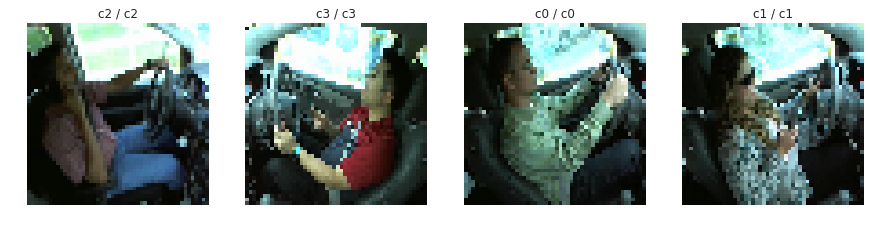

In [118]:
visualize_predictions(dsets['train'], lst_correct)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


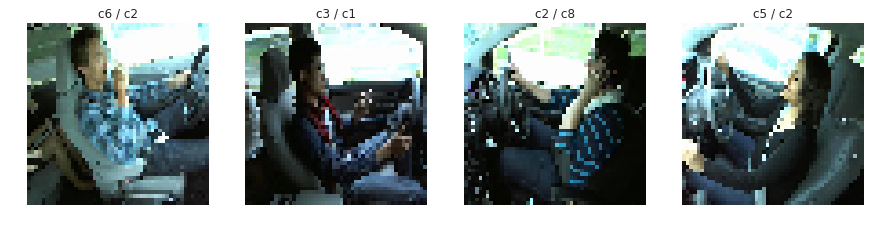

In [119]:
visualize_predictions(dsets['train'], lst_incorrect)

In [124]:
def plot_confusion(results):
    mc = np.array(pd.crosstab(results['pred'], results['true']))
    plt.imshow(mc/mc.sum(axis=1))
    plt.colorbar()
    plt.axis('off')

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


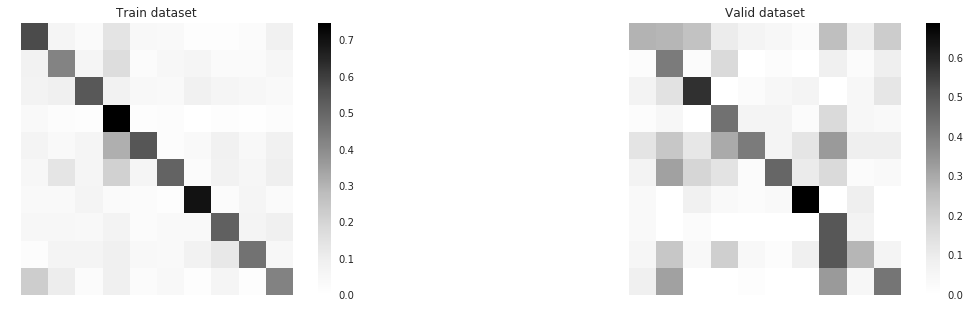

In [130]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plot_confusion(result_train)
plt.title('Train dataset')
plt.subplot(1,2,2)
plot_confusion(result_valid)
plt.title('Valid dataset')

In [120]:
def plot_layers_weight(conv_model = model.mrnc, ncols = 8, H = 14, W=30):


    rand_idx = random.randrange(0, len(dsets['train']))
    input, _ = dsets['train'][rand_idx]
    input = input.view(1, 3, 50, 50)

    if use_gpu:
        x = Variable(input.cuda())
    else:
        x = Variable(input)


    for name, layer in conv_model.named_children():
        x = layer(x)
        grid = torchvision.utils.make_grid(torch.transpose(x.data, 0, 1), normalize=True, 
                                           pad_value=1.0, padding=1).cpu().numpy()

        if name == 'max_pool':
            H /= 3/2
            W /= 3/2
        fig = plt.figure(figsize=(H,W))
        plt.imshow(grid.transpose((1,2,0)))
        plt.title(name)
        plt.axis('off')
        plt.show()

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


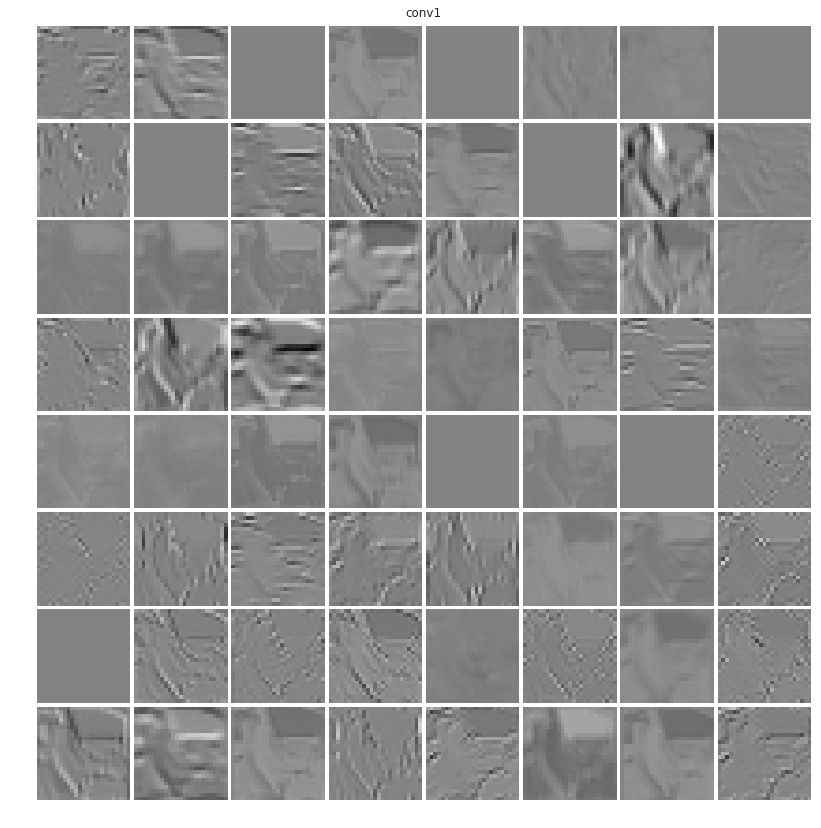

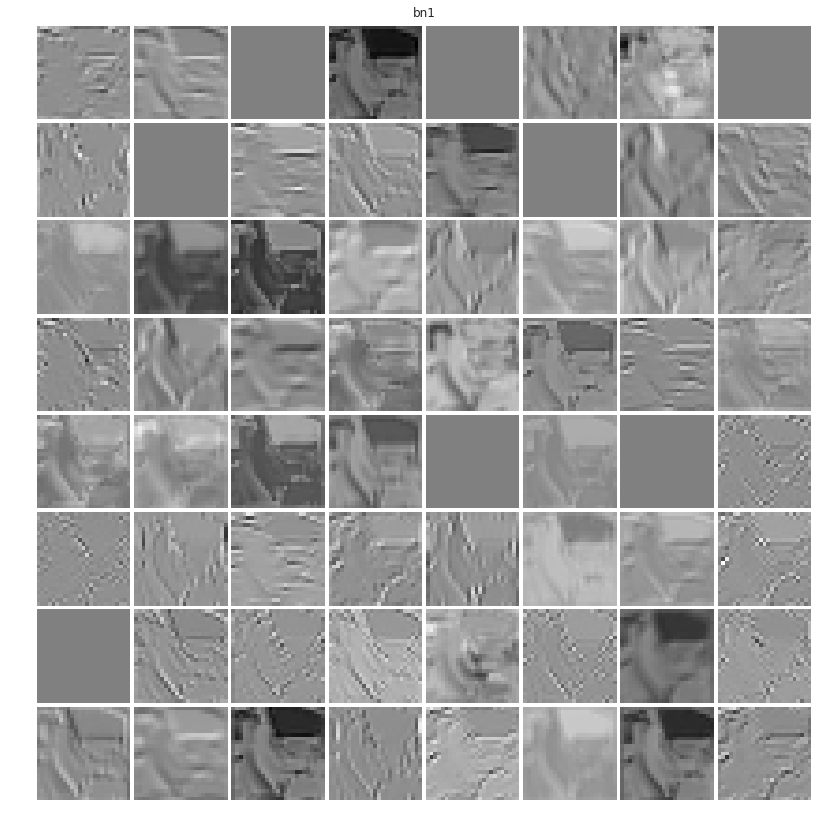

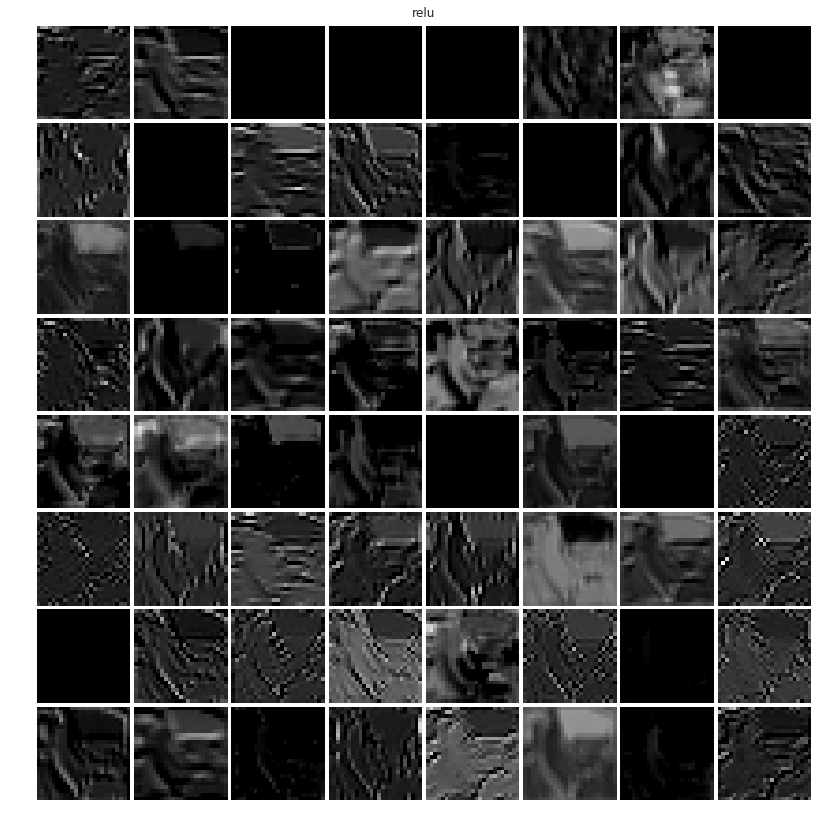

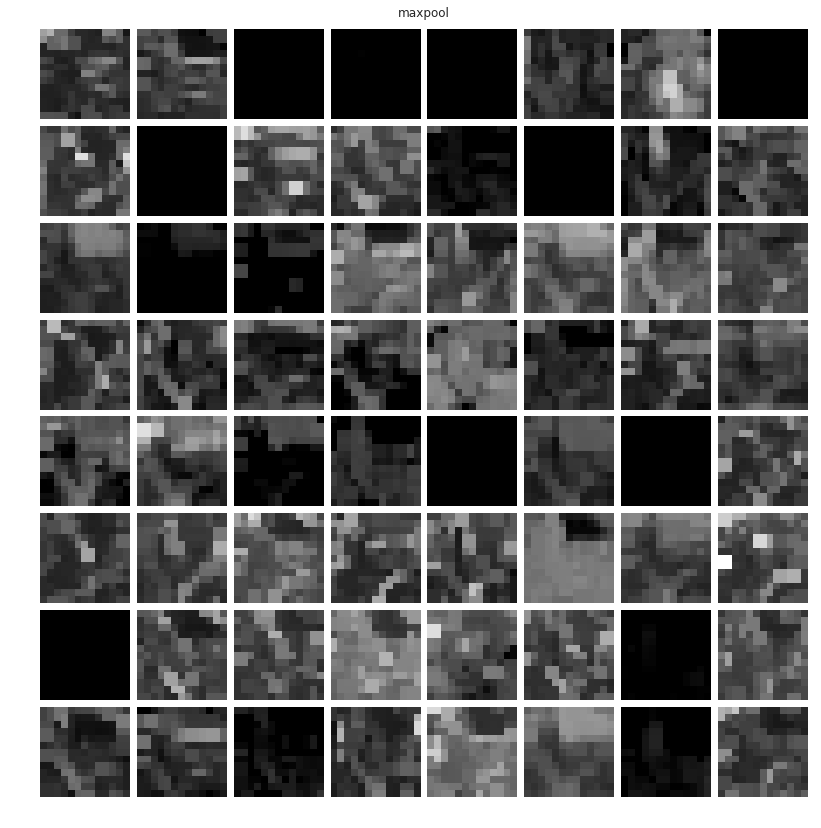

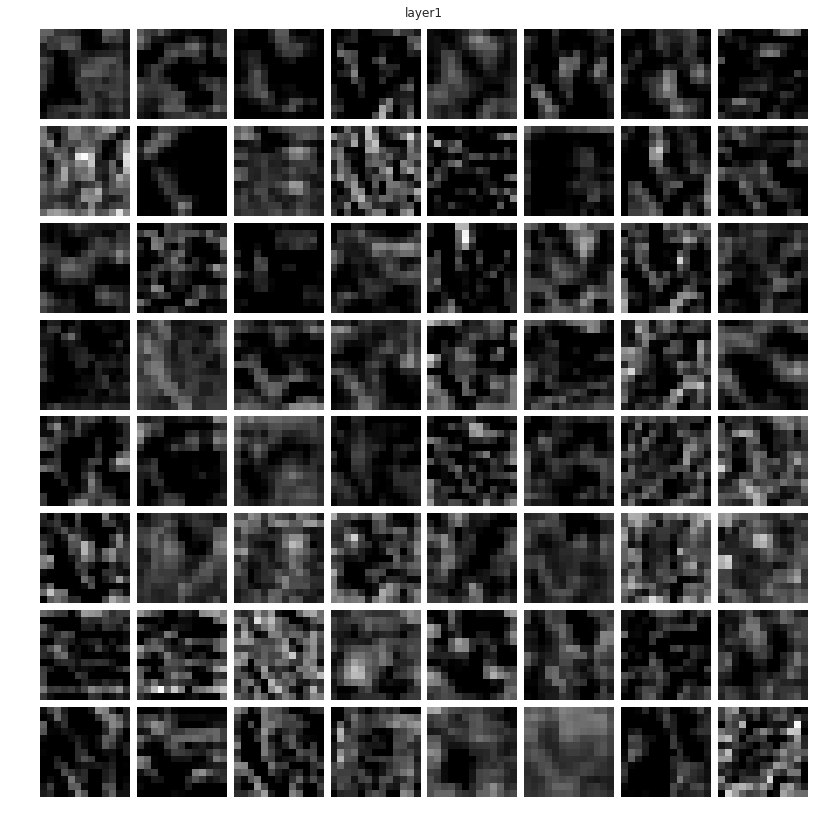

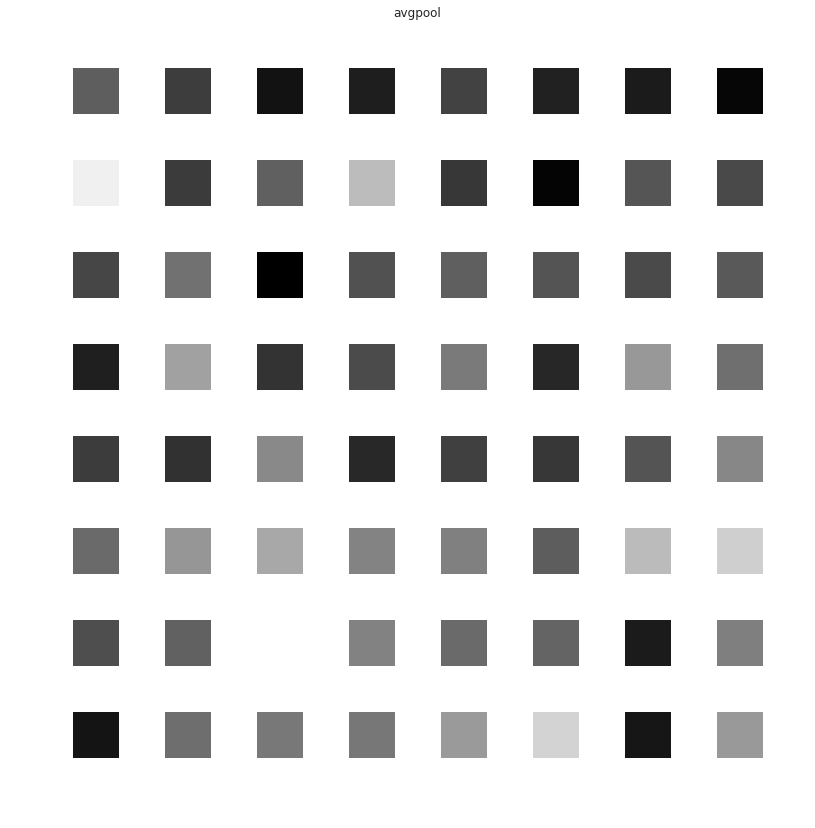

In [121]:
plot_layers_weight()